# Topic Modeling with Amortized LDA

In this tutorial, we will explore how to run the amortized Latent Dirichlet Allocation (LDA) model implementation in scvi-tools. LDA is a topic modelling method first introduced in the natural language processing field. By treating each cell as a document and each gene expression count as a word, we can carry over the method to the single-cell biology field.

Below, we will train the model over a dataset, plot the topics over a UMAP of the reference set, and inspect the topics for characteristic gene sets.

As an example, we use the PBMC 10K dataset from 10x Genomics.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:42: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import ContextualVersionConflict
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import pandas as pd
import scanpy as sc
import scvi
import seaborn as sns
import torch

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.2


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

## Load and process data

Load the 10x genomics PBMC dataset. Generally, it is good practice for LDA to remove ubiquitous genes, to prevent the model from modeling these genes as a separate topic. Here, we first filter out all mitochrondrial genes, then select the top 1000 variable genes with seurat_v3 method from the remaining genes.

In [5]:
adata_path = os.path.join(save_dir.name, "pbmc_10k_protein_v3.h5ad")
adata = sc.read(
    adata_path,
    backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad?raw=true",
)

adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=10e4)
sc.pp.log1p(adata)
adata.raw = adata  # freeze the state in `.raw`

adata = adata[:, ~adata.var_names.str.startswith("MT-")]
sc.pp.highly_variable_genes(
    adata, flavor="seurat_v3", layer="counts", n_top_genes=1000, subset=True
)

  0%|          | 0.00/23.8M [00:00<?, ?B/s]

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scanpy/preprocessing/_highly_variable_genes.py:247: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


## Create and fit `AmortizedLDA` model

Here, we initialize and fit an `AmortizedLDA` model on the dataset. We pick 10 topics to model in this case.

In [6]:
n_topics = 10

scvi.model.AmortizedLDA.setup_anndata(adata, layer="counts")
model = scvi.model.AmortizedLDA(adata, n_topics=n_topics)

```{note}
By default we train with KL annealing which means the effective loss will generally not decrease steadily in the beginning. Our Pyro implementations present this train loss term as the `elbo_train` in the progress bar which is misleading. We plan on correcting this in the future.
```

In [7]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/utilities/_pytree.py:21: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 

Training:   0%|          | 0/1000 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1000` reached.


## Visualizing learned topics

By calling `model.get_latent_representation()`, the model will compute a Monte Carlo estimate of the topic proportions for each cell. Since we use a logistic-Normal distribution to approximate the Dirichlet distribution, the model cannot compute the analytic mean. The number of samples used to compute the latent representation can be configured with the optional argument `n_samples`.

In [8]:
topic_prop = model.get_latent_representation()
topic_prop.head()

topic_0   topic_1   topic_2   topic_3   topic_4  \
index                                                                  
AAACCCAAGATTGTGA-1  0.000067  0.000083  0.791881  0.000249  0.028401   
AAACCCACATCGGTTA-1  0.000355  0.000080  0.994418  0.000145  0.004022   
AAACCCAGTACCGCGT-1  0.001367  0.000709  0.535644  0.000629  0.026290   
AAACCCAGTATCGAAA-1  0.002804  0.001986  0.001903  0.004099  0.001806   
AAACCCAGTCGTCATA-1  0.008132  0.000645  0.000678  0.000477  0.000866   

                     topic_5   topic_6   topic_7   topic_8   topic_9  
index                                                                 
AAACCCAAGATTGTGA-1  0.178944  0.000124  0.000127  0.000042  0.000081  
AAACCCACATCGGTTA-1  0.000783  0.000044  0.000082  0.000036  0.000033  
AAACCCAGTACCGCGT-1  0.431260  0.001948  0.000592  0.001299  0.000263  
AAACCCAGTATCGAAA-1  0.002473  0.003381  0.762394  0.010886  0.208269  
AAACCCAGTCGTCATA-1  0.001077  0.000553  0.719184  0.004398  0.263991

In [9]:
# Save topic proportions in obsm and obs columns.
adata.obsm["X_LDA"] = topic_prop
for i in range(n_topics):
    adata.obs[f"LDA_topic_{i}"] = topic_prop[[f"topic_{i}"]]

### Plot UMAP

In [10]:
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=20)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)

# Save UMAP to custom .obsm field.
adata.obsm["raw_counts_umap"] = adata.obsm["X_umap"].copy()

/tmp/ipykernel_102147/3535892313.py:4: FutureWarning: The `igraph` implementation of leiden clustering is *orders of magnitude faster*. Set the flavor argument to (and install if needed) 'igraph' to use it.
In the future, the default backend for leiden will be igraph instead of leidenalg. To achieve the future defaults please pass: `flavor='igraph'` and `n_iterations=2`. `directed` must also be `False` to work with igraph’s implementation.
  sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.8)


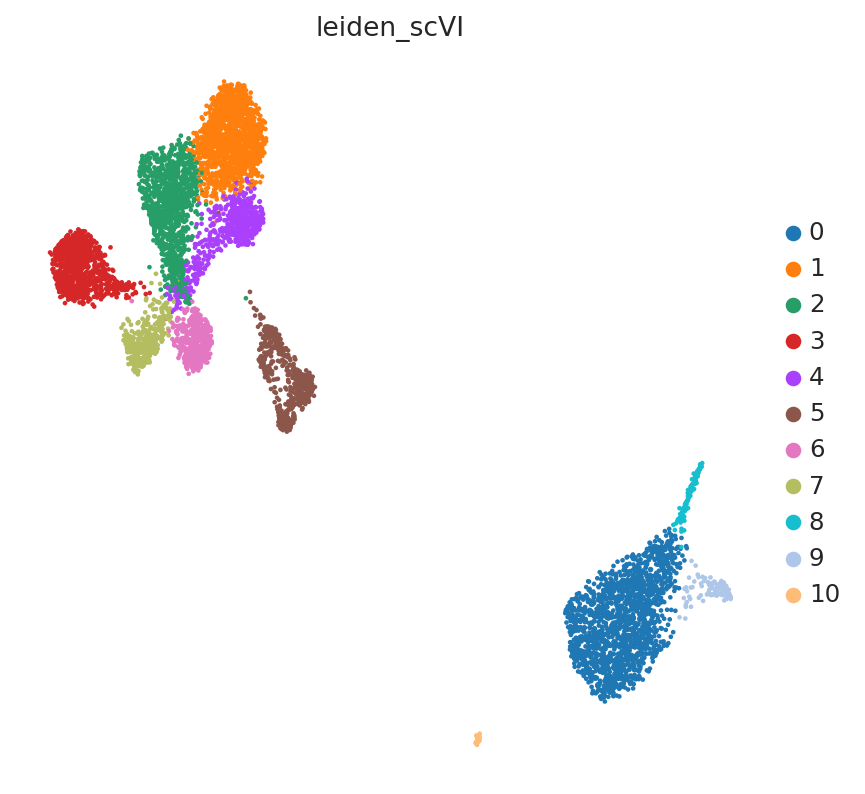

In [11]:
sc.pl.embedding(adata, "raw_counts_umap", color=["leiden_scVI"], frameon=False)

### Color UMAP by topic proportions

By coloring by UMAP by topic proportions, we find that the learned topics are generally dominant in cells close together in the UMAP space. In some cases, a topic is dominant in multiple clusters in the UMAP, which indicates similarilty between these clusters despite being far apart in the plot. This is not surprising considering that UMAP does not preserve local relationships beyond a certain threshold.

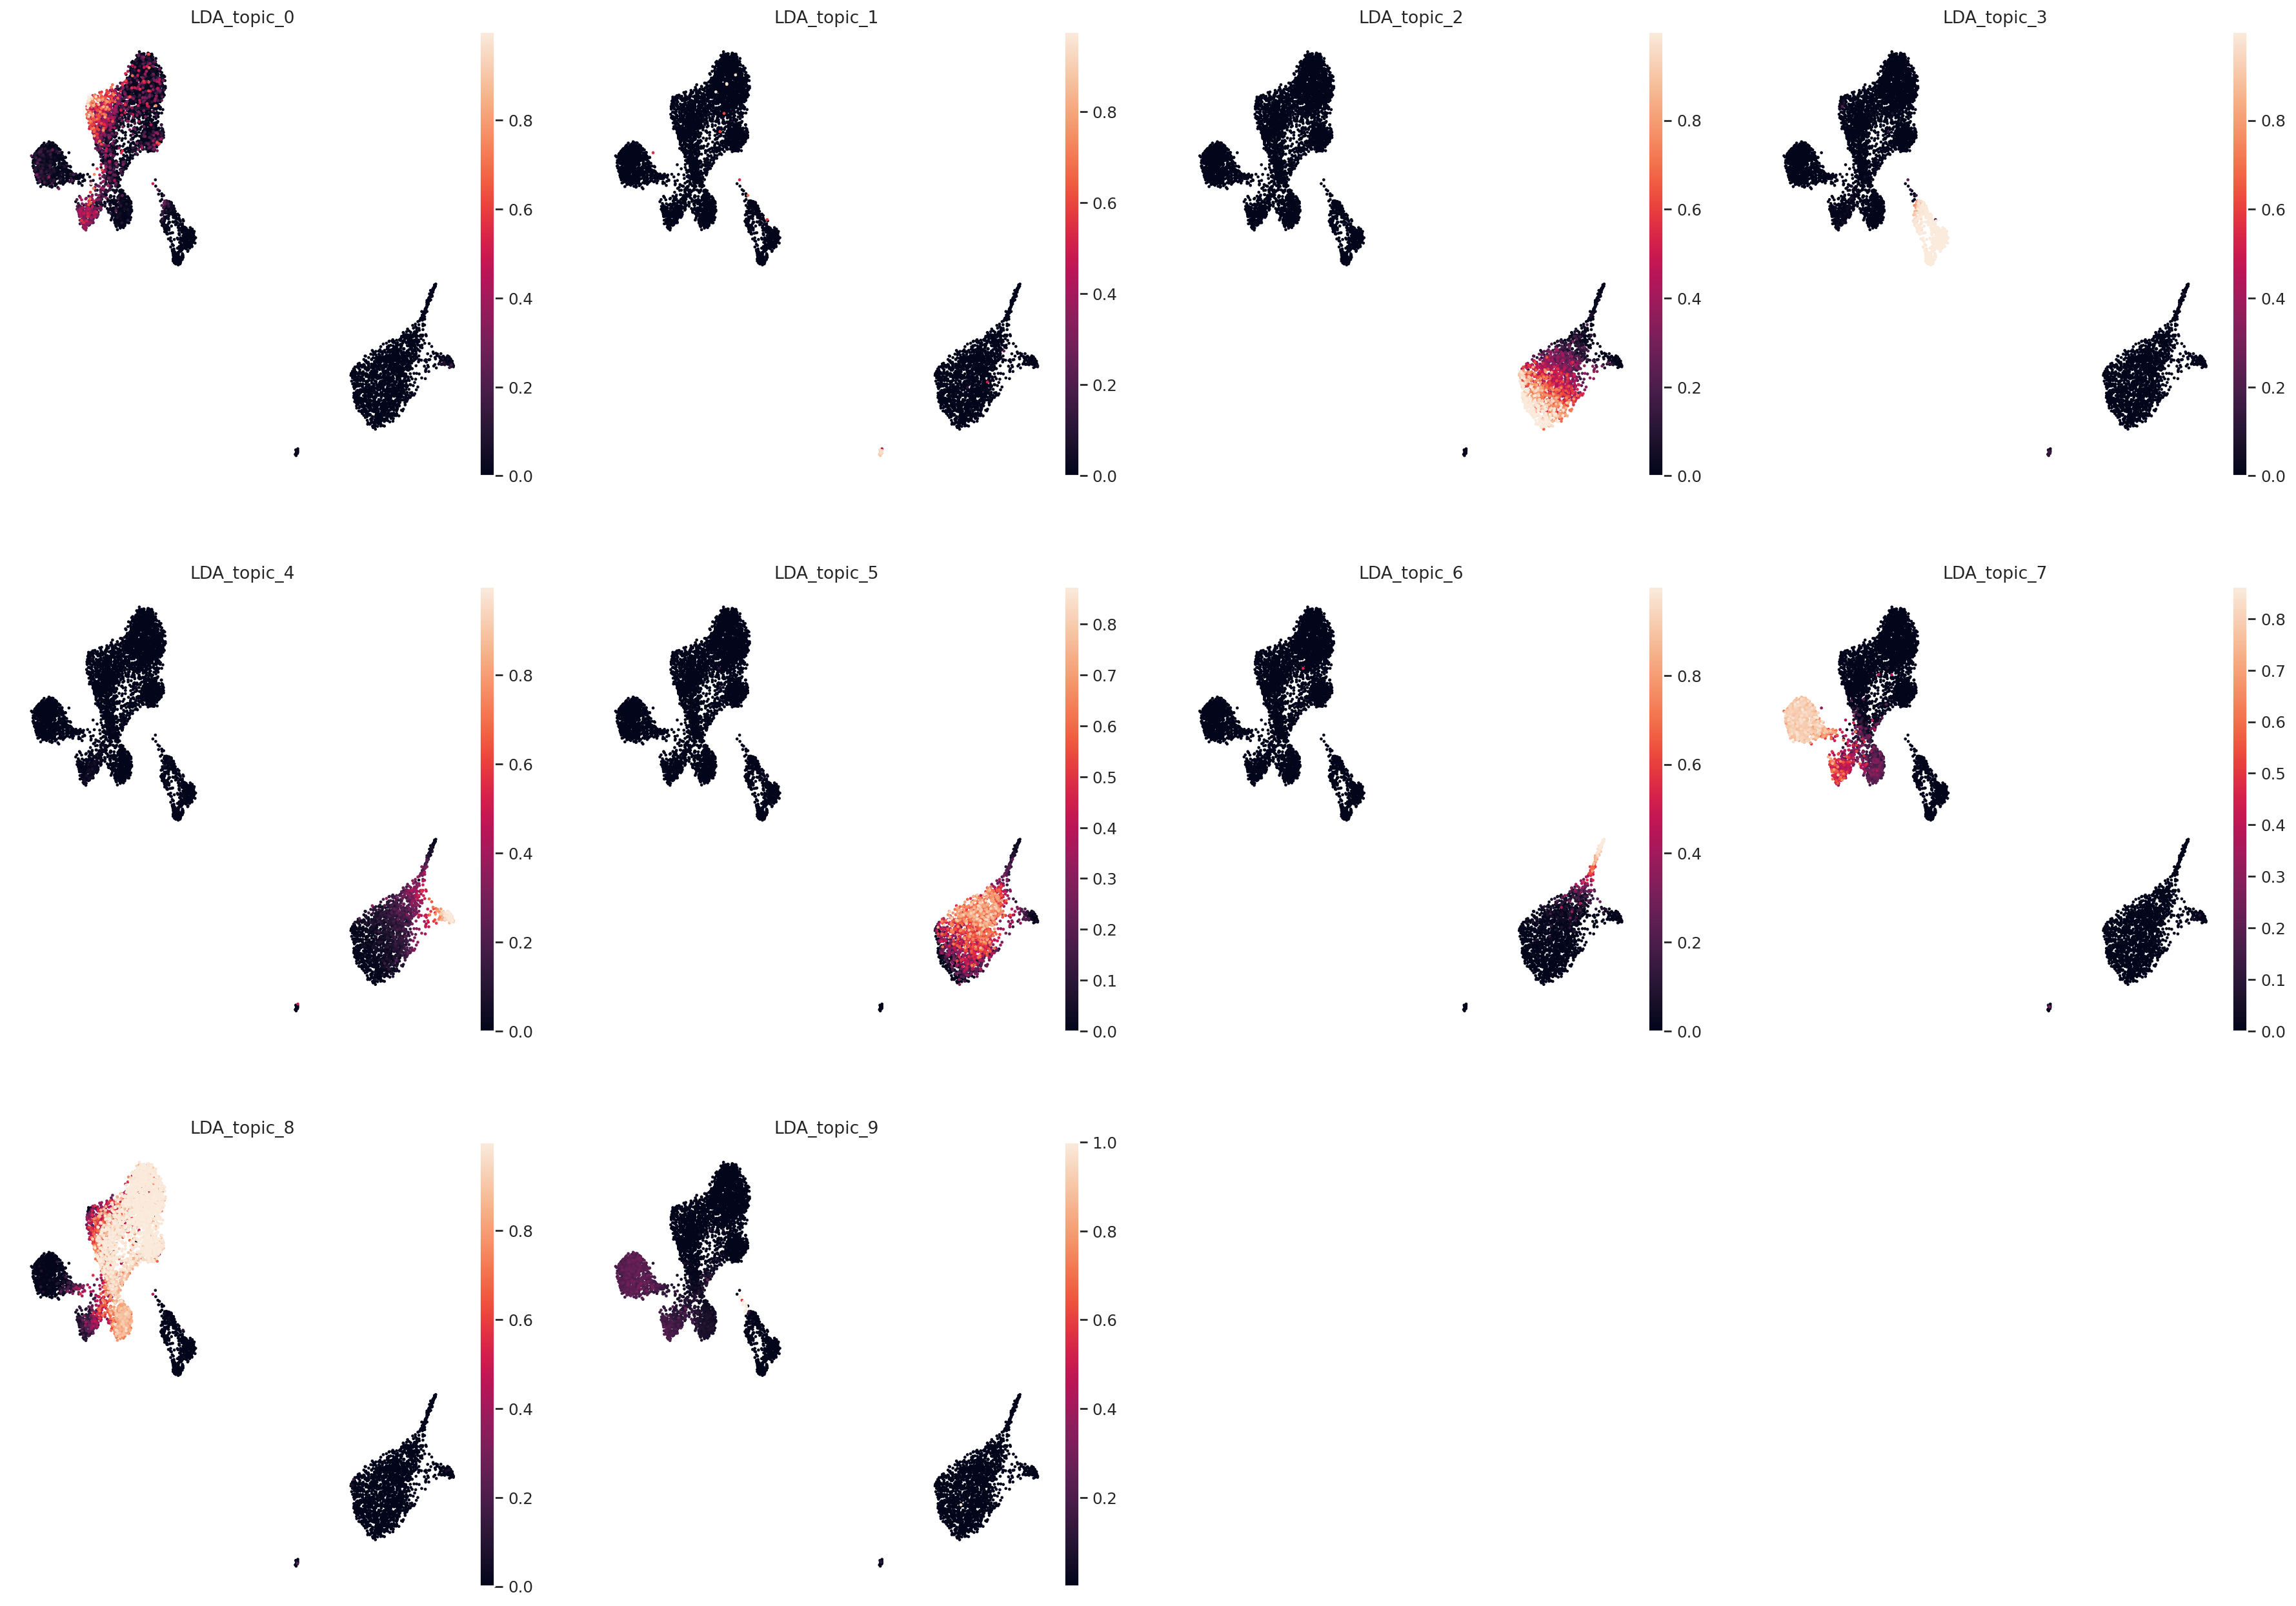

In [12]:
sc.pl.embedding(
    adata,
    "raw_counts_umap",
    color=[f"LDA_topic_{i}" for i in range(n_topics)],
    frameon=False,
)

### Plot UMAP in topic space

In [13]:
sc.pp.neighbors(adata, use_rep="X_LDA", n_neighbors=20, metric="hellinger")
sc.tl.umap(adata)

# Save UMAP to custom .obsm field.
adata.obsm["topic_space_umap"] = adata.obsm["X_umap"].copy()

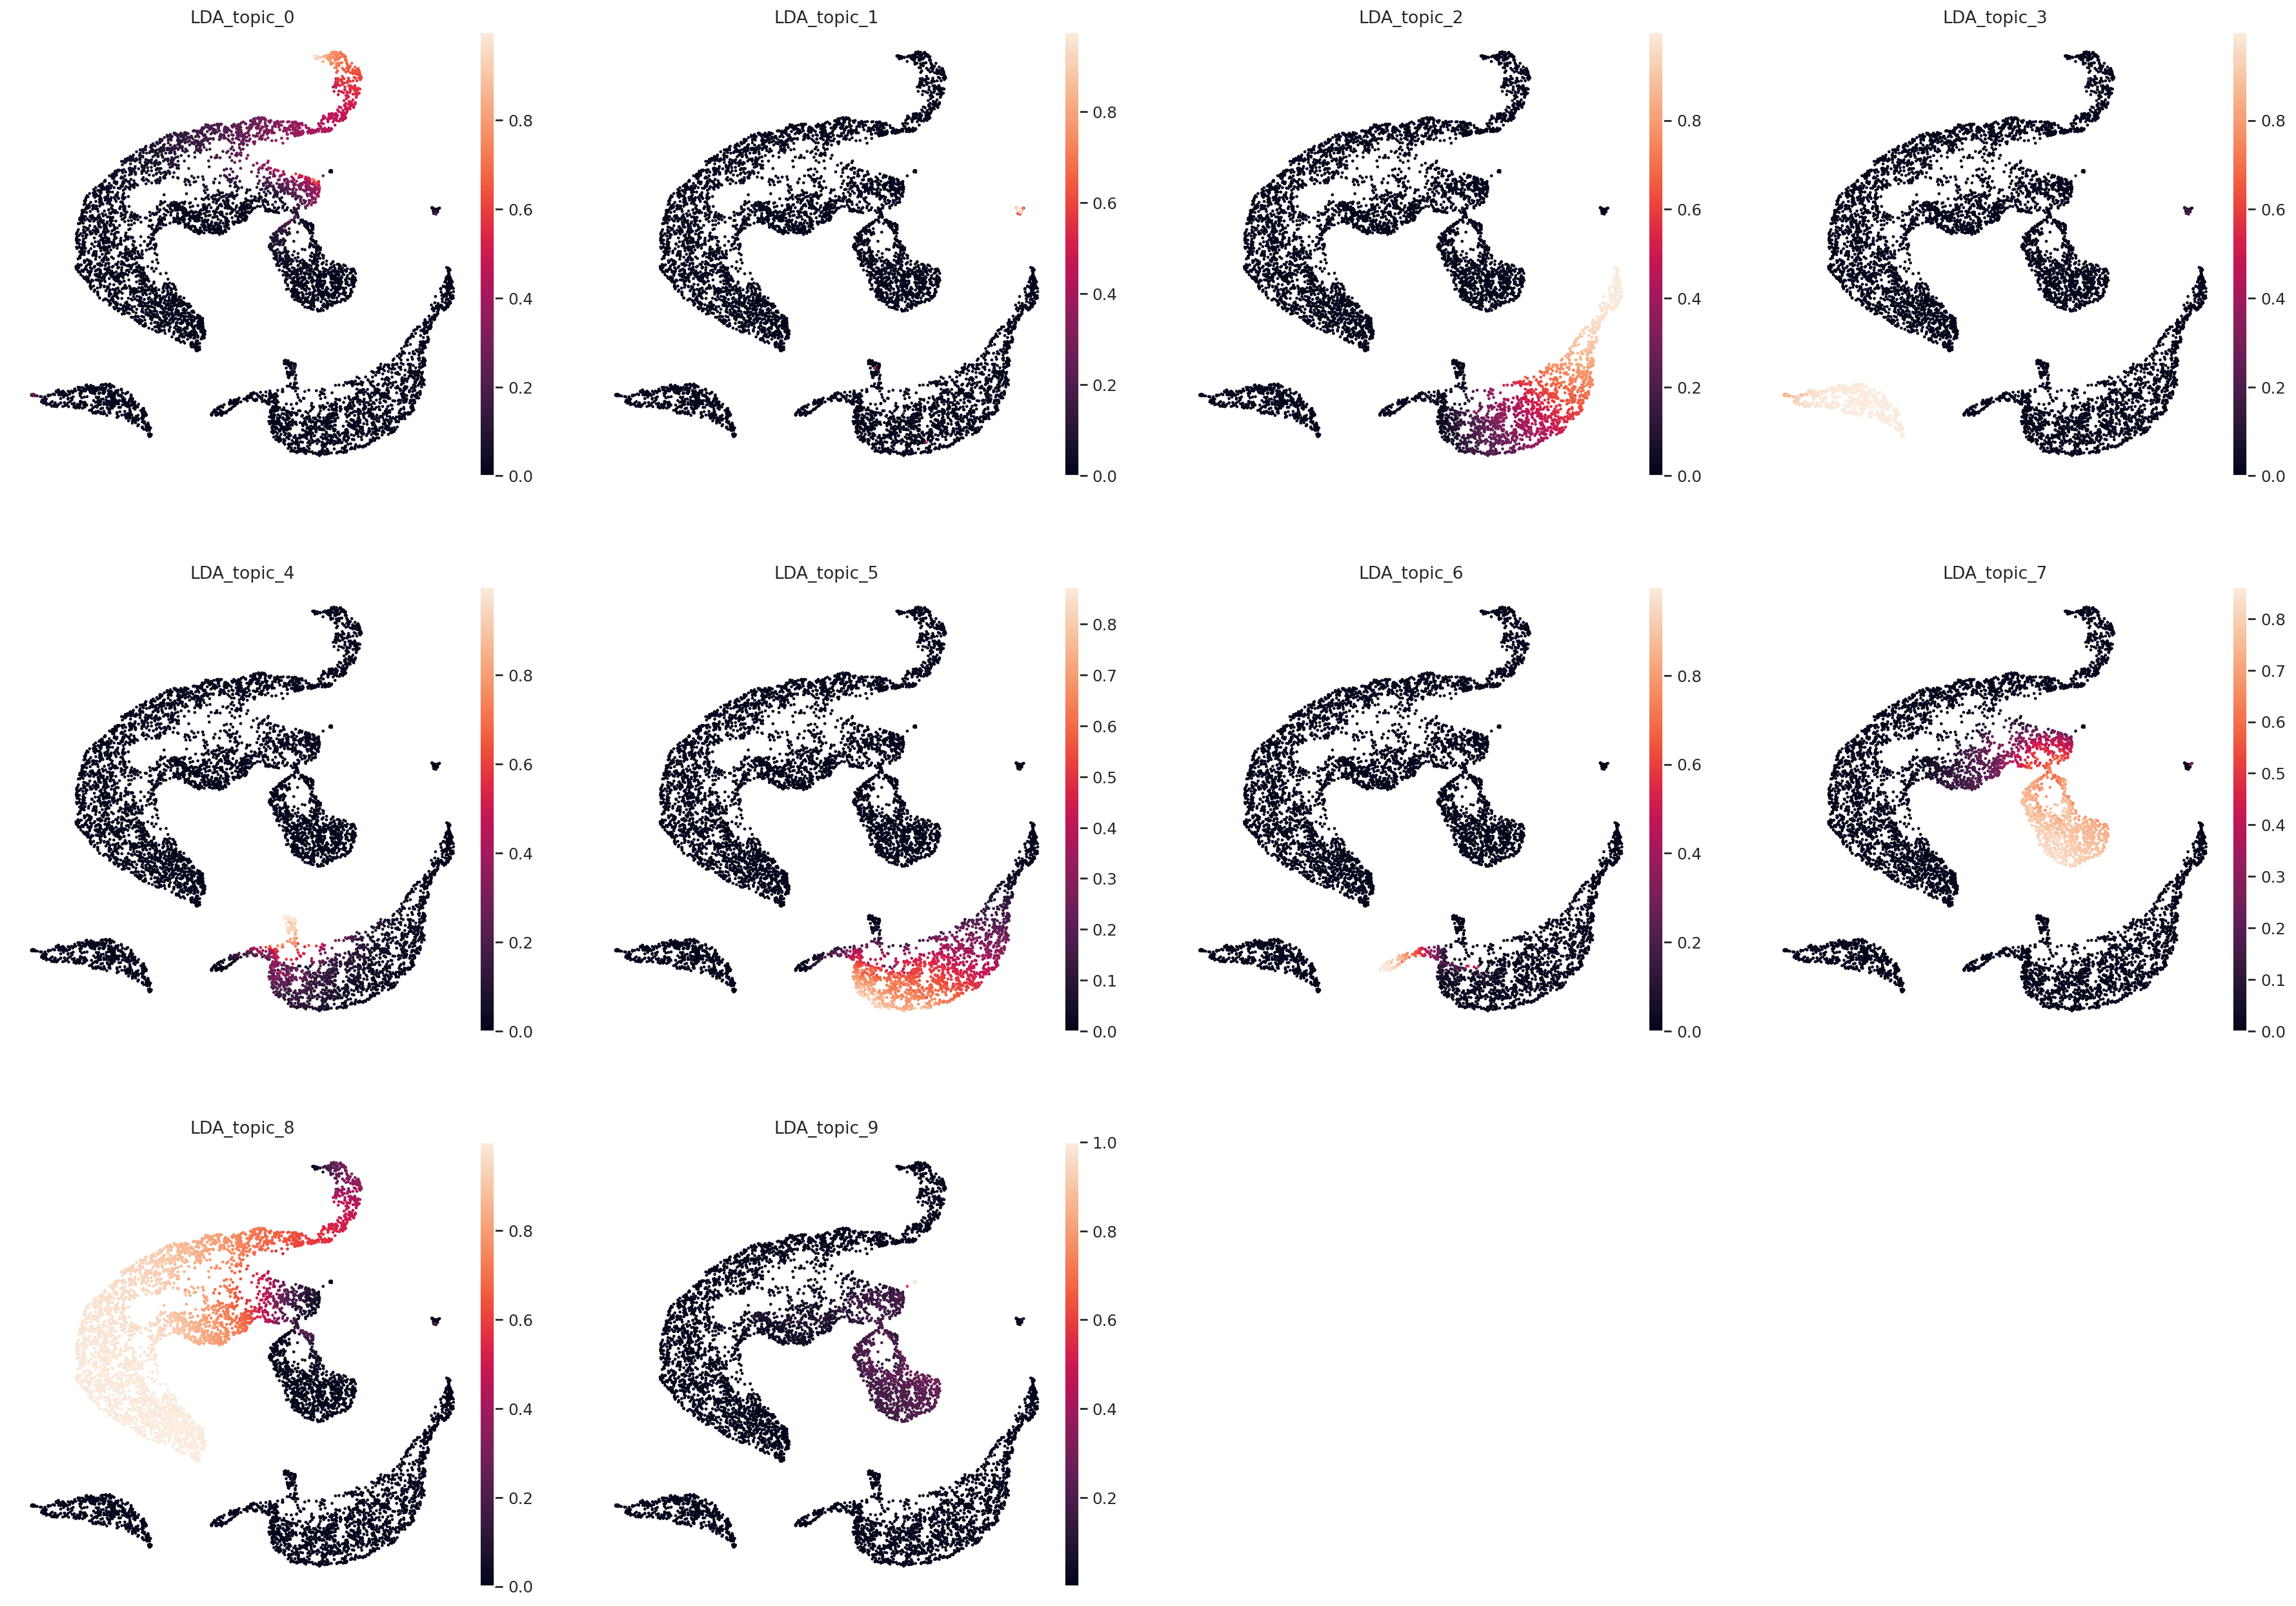

In [14]:
sc.pl.embedding(
    adata,
    "topic_space_umap",
    color=[f"LDA_topic_{i}" for i in range(n_topics)],
    frameon=False,
)

### Find top genes per topic

Similar to the topic proportions, `model.get_feature_by_topic()` returns a Monte Carlo estimate of the gene by topic matrix, which contains the proportion that a gene is weighted in each topic. This is also due to another approximation of the Dirichlet with a logistic-Normal distribution. We can inspect each topic in this matrix and sort by proportion allocated to each gene to determine top genes characterizing each topic.

In [15]:
feature_by_topic = model.get_feature_by_topic()
feature_by_topic.head()

topic_0   topic_1       topic_2   topic_3   topic_4   topic_5  \
index                                                                        
AL645608.8  0.000004  0.000021  2.584630e-06  0.000004  0.000002  0.000001   
HES4        0.000005  0.000025  7.775395e-06  0.000013  0.000010  0.000006   
ISG15       0.001438  0.000041  2.638122e-04  0.000432  0.000380  0.000474   
TNFRSF18    0.000474  0.000098  7.196131e-07  0.000028  0.000002  0.000001   
TNFRSF4     0.000700  0.000040  1.322569e-06  0.000007  0.000003  0.000001   

             topic_6   topic_7   topic_8   topic_9  
index                                               
AL645608.8  0.000032  0.000003  0.000001  0.000005  
HES4        0.000674  0.000009  0.000007  0.000006  
ISG15       0.000736  0.001791  0.001141  0.000192  
TNFRSF18    0.000003  0.000061  0.000306  0.000131  
TNFRSF4     0.000003  0.000051  0.000676  0.000012

In [16]:
rank_by_topic = pd.DataFrame()
for i in range(n_topics):
    topic_name = f"topic_{i}"
    topic = feature_by_topic[topic_name].sort_values(ascending=False)
    rank_by_topic[topic_name] = topic.index
    rank_by_topic[f"{topic_name}_prop"] = topic.values

In [17]:
rank_by_topic.head()

topic_0  topic_0_prop  topic_1  topic_1_prop topic_2  topic_2_prop  topic_3  \
0    ACTB      0.191605     CD74      0.061852  S100A9      0.142184     CD74   
1  TMSB4X      0.134309     ACTB      0.043040  S100A8      0.098740     IGKC   
2  TMSB10      0.087340   TMSB4X      0.032689     LYZ      0.057181  HLA-DRA   
3   ACTG1      0.061597     FTH1      0.027223     FTL      0.042574   TMSB4X   
4  S100A4      0.042297  HLA-DRA      0.021627    ACTB      0.040240     IGHM   

   topic_3_prop   topic_4  topic_4_prop topic_5  topic_5_prop topic_6  \
0      0.109387   HLA-DRA      0.078017    FTH1      0.063310     FTL   
1      0.063001      CD74      0.072705     FTL      0.059216    ACTB   
2      0.060019      ACTB      0.066977     LYZ      0.057700  TMSB4X   
3      0.044334    TMSB4X      0.048515  TMSB4X      0.033342    FTH1   
4      0.041840  HLA-DRB1      0.046785    ACTB      0.030895  S100A4   

   topic_6_prop topic_7  topic_7_prop topic_8  topic_8_prop topic_9  \
0      0.113057  TMSB4X      0.109844  TMSB4X      0.124022    IGKC   
1      0.069695    ACTB      0.108426  TMSB10      0.083133   IGLC2   
2      0.059973    GNLY      0.102056    ACTB      0.078424   IGHA1   
3      0.059017    NKG7      0.076737    JUNB      0.036529    CCL5   
4      0.029738  TMSB10      0.044803     FTL      0.028967    GZMA   

   topic_9_prop  
0      0.134810  
1      0.084782  
2      0.073240  
3      0.069848  
4      0.044131